## Optimización - Laboratorio 4

### Isabella Salgado 201730418
### Juan Pablo Naranjo 201730006

A continuación, se encuentran funciones útiles para dibujar poligonos en 3 dimensiones. Adicional a esto se encuentra un ejemplo para poligonos en 2D y 3D.

## Funciones para dibujar

Librerías

In [1]:
import numpy as np
from sympy import Plane, Point3D
import networkx as nx
import itertools

from matplotlib.patches import Circle
from scipy.optimize import linprog
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull
import scipy as sp
from itertools import combinations
from IPython.display import display
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
from mpl_toolkits import mplot3d

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

Funciones para dibujar

In [2]:
def simplify(triangles):

    # create a graph in which nodes represent triangles;
    # nodes are connected if the corresponding triangles are adjacent and coplanar
    G = nx.Graph()
    G.add_nodes_from(range(len(triangles)))
    for ii, a in enumerate(triangles):
        for jj, b in enumerate(triangles):
            if (ii < jj): # test relationships only in one way as adjacency and co-planarity are bijective
                if is_adjacent(a, b):
                    if is_coplanar(a, b, np.pi / 180.):
                        G.add_edge(ii,jj)
    # flatten function
    flatten = lambda l: [item for sublist in l for item in sublist]

    # triangles that belong to a connected component can be combined
    components = list(nx.connected_components(G))
    simplified = [set(flatten(triangles[index] for index in component)) for component in components]

    # need to reorder nodes so that patches are plotted correctly
    reordered = [list(reorder(face)) for face in simplified]

    return reordered


def is_adjacent(a, b):
    return len(set(a) & set(b)) == 2 # i.e. triangles share 2 points and hence a side


def is_coplanar(a, b, tolerance_in_radians=0):
    a1, a2, a3 = a
    b1, b2, b3 = b
    plane_a = Plane(Point3D(a1), Point3D(a2), Point3D(a3))
    plane_b = Plane(Point3D(b1), Point3D(b2), Point3D(b3))
    if not tolerance_in_radians: # only accept exact results
        return plane_a.is_coplanar(plane_b)
    else:
        angle = plane_a.angle_between(plane_b).evalf()
        angle %= np.pi # make sure that angle is between 0 and np.pi
        return (angle - tolerance_in_radians <= 0.) or \
            ((np.pi - angle) - tolerance_in_radians <= 0.)


def reorder(vertices):
    # Reorders nodes so they form a face
    # Tolerance to error in degree angle
    tolerance = 0.05
    
    if len(vertices) <= 3: # just a triangle
        return vertices
    else:
        vertices = list(vertices)
        combinations = get_combinations(len(vertices))
        angle = 180*(len(vertices)-2) 
        
        for comb in combinations:
            
            reordered = [vertices[c] for c in comb]
            inner_angle = get_innerAngle(reordered)
            
            if (inner_angle < angle + tolerance) and (inner_angle > angle - tolerance):
                return reordered
            

def get_combinations(n):
    stuff = range(n)
    out = []
    for L in range(0, len(stuff)+1):
        for subset in itertools.permutations(stuff, L):
            if (len(subset) == len(stuff)) and (subset[0] == stuff[0]):
                out.append(subset)
    
    return(out)
    
def get_angle3D(a,b,c):
    ba = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def get_innerAngle(vertices):
    tmp = vertices.copy()
    # Add information to do calculations
    tmp = [tmp[-1]] + tmp + [tmp[0]]
    
    angle = 0
    
    for i in range(1,len(tmp)-1):
        angle += get_angle3D(tmp[i-1],tmp[i],tmp[i+1])
    
    return angle
    

def get_distance(v1, v2):
    v2 = np.array(list(v2))
    difference = v2 - v1
    ssd = np.sum(difference**2, axis=1)
    return np.sqrt(ssd)

def polygon3D(halfspaces, feasible_point, options):
    
    hs = HalfspaceIntersection(halfspaces, feasible_point)
    verts = hs.intersections
    hull = ConvexHull(verts)
    faces = hull.simplices
    
    triangles = []
    for s in faces:
        sq = [
            (verts[s[0], 0], verts[s[0], 1], verts[s[0], 2]),
            (verts[s[1], 0], verts[s[1], 1], verts[s[1], 2]),
            (verts[s[2], 0], verts[s[2], 1], verts[s[2], 2])
        ]
        triangles.append(sq)
    
    new_faces = simplify(triangles)
    
    # Create Figure
    ax = a3.Axes3D(plt.figure())

    ax.dist= options['distance']
    ax.azim= options['assymetry']
    ax.elev= options['elevation']
    
    for sq in new_faces:
        f = a3.art3d.Poly3DCollection([sq])
        f.set_color(colors.rgb2hex(sp.rand(3)))
        f.set_edgecolor('k')
        f.set_alpha(0.4)
        ax.add_collection3d(f)
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(options['title'])
    
    xpoints = [it[0] for it in verts]
    ypoints = [it[1] for it in verts]
    zpoints = [it[2] for it in verts]

    
    scale = np.max([np.max(xpoints),np.max(ypoints),np.max(zpoints)])/15
    
    ax.set_xlim(np.min(xpoints) - scale/2, np.max(xpoints) + scale)
    ax.set_ylim(np.min(ypoints) - scale/2, np.max(ypoints) + scale)
    ax.set_zlim(np.min(zpoints) - scale/2, np.max(zpoints) + scale)
                
    return ax

def polygon2D(vertices, options):
    
    path_points = reorder(vertices)
    path_points = list(path_points) + list([path_points[0]])

    # Dibujar forma a partir de los puntos
    path = mpl.path.Path(path_points)            
    patch = mpl.patches.PathPatch(path, facecolor= options['color'])               
    # Add to plot
    plt.gca().add_patch(patch)

    plt.xlabel('x')
    plt.ylabel('y')

    xpoints = [it[0] for it in path_points]
    ypoints = [it[1] for it in path_points]

    scale = np.max([np.max(xpoints),np.max(ypoints)])/15

    plt.xlim(np.min(xpoints) - scale/2, np.max(xpoints) + scale)
    plt.ylim(np.min(ypoints) - scale/2, np.max(ypoints) + scale)

    plt.gca().set_aspect('equal', adjustable='box')

    ax = plt.gca()
    ax.set_title(options['title'])

    return ax

### A continuación se presenta la defincición de la función que encuentra las soluciones básicas de un problema de optimización en la forma estándar.

In [3]:
def func(A,b):
    
    # Se crea un diccionario cuyas llaves y valores ambas son listas vacías.
    dir = {'Solución':[], 'Base':[]}
    
    # Se determina la dimensión de la matriz y vector de entrada.
    sizeA = np.shape(A) # m ecuaciones
    sizeb = np.shape(b) # n incógnitas
    
    # Se usa la función combinations para encontrar todas las combinaciones posibles que se pueden hacer
    # con las m ecuaciones y n incógnitas. Las componentes de cada tupla que retorna la función indica qué
    # columnas de la matriz se eliminan, es decir, qué variables se están mandando a cero para resolver el 
    # sistema de ecuaciones resultante. La cantidad de combinaciones que resultan es la cantidad de soluciones
    # básicas que tiene el problema de optimización. 
    combs = combinations(list(range(0,sizeA[1])),(sizeA[1]-sizeA[0]))
    
    # Vamos a examinar todas las posibles combinaciones de variables igualadas a cero.
    for item in list(combs):
        
        # Se crea una copia de la matriz, llamada A_1
        A_1 = A.copy()
        
        # Se eliminan las item-ésimas (números de la tupla) columnas (indicadas por axis=1) de A_1, es decir, se mandan
        # a cero las variables correspondientes a esas columnas. 
        A_1 = np.delete(A_1,item,axis=1)
        
        # Se crea otra copia de la matriz, llamada A_2
        A_2 = A.copy()
        
        # Se ponen las item-ésimas (números de la tupla) columnas de A_2 en cero para indicar cómo queda el sistema cuando 
        # se mandan esas variables a cero. Estas son las bases correspondientes a cada solución básica.
        A_2[:,item] = 0
        
        # La solución básica está dada por la solución del sistema resultante al mandar las m-n variables a cero.
        # Si la matriz del sistema de ecuaciones resultante es singular, se agrega la palabra 'Singular' a las llaves, y su
        # respectiva base a los valores.
        if (np.linalg.det(A_1)==0):
            dir['Solución'].append('Matriz singular')
            dir['Base'].append(A_2)
        # Si la matriz sí se puede invertir, se encuentra la solución básica sin problema. Después de encontrar estos valores,
        # se vuelven a agregar las columnas que se eliminaron previamente, y se agregan como un cero en la item-ésima
        # componente de cada solución básica. 
        else:
            ans = np.dot(np.linalg.inv(A_1),b)
            ans = np.round(ans,3)
            # Se usa este ciclo para recorrer las item-ésimas componentes de las soluciones básicas (las que se habían
            # eliminado previamente). En cada componente se agrega un cero.
            for i in item:
                ans = np.insert(ans, i, 0, axis=0)
            # Se agregan las soluciones básicas a la llave 'Solución' del diccionario, y las matrices resultantes al valor 'Base'.
            dir['Solución'].append(ans)
            dir['Base'].append(A_2)
             
                               
    return dir

### A continuación se presenta la implementación de la función que determina las soluciones báscias factibles de un problema de optimización en la forma estándar, a partir de las soluciones básicas.

In [4]:
def fun(A,b):
    
    # Se crea un diccionario con dos llaves. Los valores de la llave 'Factibles' corresponden a las soluciones básicas 
    # factibles. Los valores de la llave 'Base' corresponden a las bases correspondientes a las soluciones básicas 
    # factibles.
    factibles = {'Factibles': [], 'Base': []}
    
    # Se llama a la función creada previamente para determinar cuáles son las soluciones básicas.
    res1 = func(A,b)
    
    # Las soluciones básicas corresponden a los valores de la llave 'Solución' del diccionario entregado por la función
    # del punto 1. Las bases de estas soluciones básicas corresponden a los valores de la llave 'Base' del diccionario 
    # entregado por la función del punto 1.
    sols_basicas = res1['Solución']
    bases_basicas = res1['Base']

    # Las soluciones básicas factibles corresponden a los valores de la llave 'Solución' del diccionario creado
    # anteriormente. Las bases de estas soluciones básicas factibles corresponden a los valores de la llave 'Base' 
    # del diccionario creado anteriormente. 
    sols_factibles = factibles['Factibles']
    bases_factibles = factibles['Base']
       
    # Se recorren todas las soluciones básicas. Si todas las componentes del vector correspondiente a una solución básica
    # son mayores o iguales a cero, esta solución es básica y por lo tanto se agrega el valor de esta solución básica al
    # diccionario de soluciones básicas factibles. De igual forma, se agrega el valor de la base correspondiente a esa 
    # solución básica al diccionario. 
    for solucion in sols_basicas:
        if solucion == 'Matriz singular':
            pass
        else:
            if all(x>=0 for x in solucion) == True:
                factibles['Factibles'].append(solucion)
                factibles['Base'].append(res1.get('Base', solucion))
            else:
                pass
            
    # Se preseta la información obtenida por la función en una tabla ordenada haciendo uso de la librería pandas.
    tabla1 = pd.DataFrame({
        'Solución': sols_factibles,
        'Base': bases_factibles
    })

    display(tabla1)
    
    return factibles

# 1) Definición de una función que grafica la región factible de un problema de optimización en la forma estándar.

In [5]:
# Esta función dibuja la región factible de un problema de optimización de dos o tres variables de decisión en espacio 2D
# o 3D. Como parámetro recibe una matriz cuyas filas corresponden a las ecuaciones de los diferentes semiespacios que
# encierran a la región factible.

def genRegionFactible(halfspaces):
    
    # Se obtiene la dimensión de la matriz de semiespacios.
    sizeA = np.shape(halfspaces)
    
    # Se concatena la submatriz halfspaces sin la última columna con los vectores de variable de holgura, representados por 
    # una matriz identidad con el mismo número de filas que la matriz de semiespacios.
    A = np.concatenate((halfspaces[:,:-1],np.identity(halfspaces.shape[0])),axis=1)
    
    # El vector b está dado por el negativo de la última columna de la matriz de semiespacios.
    b = -1*halfspaces[:,-1]
    
    # Se encuentran las soluciones básicas factibles del problema de optimización.
    var2 = fun(A,b)
    
    # Se crea una lista vacía para después llenarla con las soluciones básicas factibles del problema. Estas soluciones
    # básicas factibles corresponden a los vértices del polígono generado por la intersección de los semiespacios.
    vertices = []
    
    # Si el problema de optimización tiene menos de 3 variables (4 dimensiones en la forma en que se define la matriz de
    # subespacios), se lleva a cabo el procedimiento de dibujar con la función polygon2D.
    if sizeA[1] < 4:

        # Se recorre la lista de soluciones básicas factibles y cada elemento de la lista se agrega a la lista de vértices.
        # Solo se agregan los primeros dos elementos del vector de soluciones básicas factibles, que corresponden a las 
        # variables de decisión, y no a las variables de holgura.
        for item in list(var2['Factibles']):
            lista = list(item)
            vertices.append(lista[:2])

        # Opciones para el color, etiquetas y título de la gráfica generada.
        options = {'color': 'lightblue',
                   'xlabel': 'x' ,
                   'ylabel': 'y',
                   'title':'Región Factible'}

        # Se dibuja la región factible a partir de las soluciones básicas factibles.
        ax = polygon2D(vertices, options)

        # Se marca cada solución básica factible con un punto rojo.
        for item in vertices:
            ax.scatter(item[0], item[1], c = 'red' , marker = '.', s = 180)
    
    # Si el problema de optimización tiene exactamente 3 variables (4 dimensiones en la forma en que se define la matriz de
    # subespacios), se lleva a cabo el procedimiento de dibujar con la función polygon3D.
    elif sizeA[1] == 4:
        
        # Se recorre la lista de soluciones básicas factibles y cada elemento de la lista se agrega a la lista de vértices.
        # Solo se agregan los primeros tres elementos del vector de soluciones básicas factibles, que corresponden a las 
        # variables de decisión, y no a las variables de holgura.
        for item in list(var2['Factibles']):
            lista = list(item)
            vertices.append(lista[:3])
        
        # Para poder graficar en tres dimensiones, se requiere agregar 3 filas a la matriz de semiespacios,
        # correspondientes a las variables de holgura. 
        halfspaces3d = np.append(halfspaces, [[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0]], axis=0)
        
        # Opciones para graficar en 3D
        options = {'distance': 10,
                   'assymetry':10,
                   'elevation':10,
                   'title':'Región Factible'}

        # Se necesita también un punto dentro de la región factible. Este punto se va a pedir como input del usuario.
        feasible_point = []
        
        # Si el punto seleccionado por el usuario está dentro de la región factible y el punto consiste de solo 3
        # coordenadas, se logra dibujar la región factible.
        try:
            feasible_point = [float(item) for item in input("Escriba las coordenadas x, y, z (en ese orden) del punto dentro de la región factible separadas por espacios: ").split()] 

            feasible_point = np.asarray(feasible_point) 

            # Se dibuja la región factible a partir de las soluciones básicas factibles.
            ax = polygon3D(halfspaces3d, feasible_point, options)

            # Se marca cada solución básica factible con un punto rojo.
            for item in vertices:
                ax.scatter(item[0], item[1], item[2], c = 'red', marker = '.', s = 180)
                
        # Si el punto seleccionado por el usuario no está dentro de la región factible o el usuario no escribió bien el
        # punto dentro de la región factible, se muestra un error.
        except:
            print("Ocurrió alguna de estas cuatro: \n 1. El punto no está dentro de la región factible \n 2. Escribió más de tres coordenadas \n 3. No escribió números \n 4. No separó por espacios ")

**IMPORTANTE**: Tener en cuenta que para que la función entregue resultados correctos, los semiespacios deben estar declarados de la forma $$Ax \leq -b$$

Información sobre cómo obtener una lista como input del usuario se encontró [aquí](https://www.geeksforgeeks.org/python-get-a-list-as-input-from-user/). 

Información sobre cómo pasar una lista a un array de tipo *numpy* se encontró [aquí](https://numpy.org/doc/stable/reference/generated/numpy.asarray.html)

### Ejemplo de la gráfica de una región factible en 2 dimensiones

,Solución,Base
0,"[0.0, 0.0, 4.0, 4.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 2.0, 2.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[2.0, 0.0, 0.0, 6.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[0.8, 2.4, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


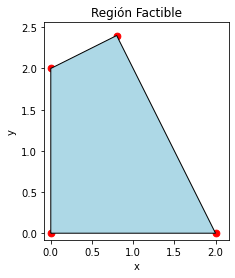

In [6]:
halfspaces = np.array([[2, 1, -4],
                       [-1, 2, -4]])

genRegionFactible(halfspaces)

### Ejemplo de la gráfica de una región factible en 3 dimensiones

In [7]:
halfspaces = np.array([
                    [1, 1, 1, -10 ],
                    [ 1.,  0.,  0., -4],
                    [ 0.,  1.,  0., -4],
                    [ 0.,  0.,  1., -4],
                    [-1.,  0.,  0.,  0],
                    [ 0., -2.,  0.,  0],
                    [ 0.,  0., -1.,  0]
                    ])
    
genRegionFactible(halfspaces)

,Solución,Base
0,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,"[0.0, 0.0, 4.0, 6.0, 4.0, 4.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,"[0.0, 4.0, 0.0, 6.0, 4.0, 0.0, 4.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,"[0.0, 4.0, 4.0, 2.0, 4.0, 0.0, 0.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,"[0.0, 4.0, 0.0, 6.0, 4.0, 0.0, 4.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,"[0.0, 0.0, 4.0, 6.0, 4.0, 4.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,"[4.0, 0.0, 0.0, 6.0, 0.0, 4.0, 4.0, 4.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


Ocurrió alguna de estas cuatro: 
 1. El punto no está dentro de la región factible 
 2. Escribió más de tres coordenadas 
 3. No escribió números 
 4. No separó por espacios 


# 2) Gráficas de diferentes regiones factibles
### a)

Región factible delimitada por:

$2x + y \leq 50$ \
$x + 2y \leq 70$ \
$x, y \geq 0$

,Solución,Base
0,"[0.0, 0.0, 50.0, 70.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 35.0, 15.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[25.0, 0.0, 0.0, 45.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[10.0, 30.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


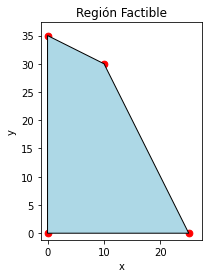

In [8]:
halfspaces = np.array([[2, 1, -50],
                       [1, 2, -70]])

genRegionFactible(halfspaces)

### b)
Región factible delimitada por:

$x + y \geq 50$ \
$x \leq 30$ \
$y \leq 40$ \
$x, y \geq 0$

,Solución,Base
0,"[30.0, 20.0, 0.0, 0.0, 20.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[10.0, 40.0, 0.0, 20.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[30.0, 40.0, 20.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


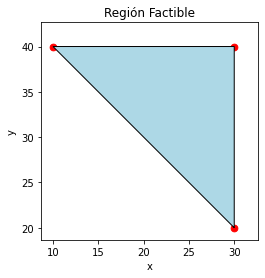

In [9]:
halfspaces = np.array([[-1, -1, 50],
                       [1, 0, -30],
                      [0,1, -40]])

genRegionFactible(halfspaces)

### c)
Región factible delimitada por:

$-3x + 2y \leq 6$ \
$5x + 4y \geq 20$ \
$8x + 3y \leq 24$ \
$x, y \geq 0$

,Solución,Base
0,"[0.727, 4.091, 0.0, 0.0, 5.909]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[1.2, 4.8, 0.0, 5.2, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[2.118, 2.353, 7.647, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


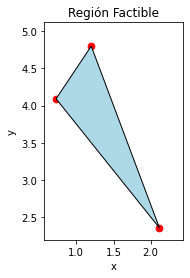

In [10]:
halfspaces = np.array([[-3, 2, -6],
                       [-5, -4, 20],
                      [8,3, -24]])

genRegionFactible(halfspaces)

### d)

Región delimitada por:

$2x + 3y + 2z \leq 6$ \
$3x - 2z \leq 4$ \
$x, y, z \geq 0$

In [11]:
halfspaces = np.array([[2, 3, 2, -6],
                       [3, 0, -2, -4]])

genRegionFactible(halfspaces)

,Solución,Base
0,"[0.0, 0.0, 0.0, 6.0, 4.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
1,"[0.0, 0.0, 3.0, 0.0, 10.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,"[0.0, 2.0, 0.0, 0.0, 4.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,"[1.333, 0.0, 0.0, 3.333, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
4,"[2.0, 0.0, 1.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
5,"[1.333, 1.111, 0.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."


Ocurrió alguna de estas cuatro: 
 1. El punto no está dentro de la región factible 
 2. Escribió más de tres coordenadas 
 3. No escribió números 
 4. No separó por espacios 


### e)

Región delimitada por:

$2x + 3y + 5z \leq 8$ \
$3x - 2y + 2z \leq 4$ \
$2x + y - 3z \leq 6 $ \
$x, y, z \geq 0$

In [12]:
halfspaces = np.array([[2, 3, 5, -8],
                       [3, -2, 2, -4],
                       [2, 1, 3, -6]])

genRegionFactible(halfspaces)

,Solución,Base
0,"[0.0, 0.0, 0.0, 8.0, 4.0, 6.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
1,"[0.0, 0.0, 1.6, 0.0, 0.8, 1.2]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
2,"[0.0, 2.667, 0.0, 0.0, 9.333, 3.333]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
3,"[1.333, 0.0, 0.0, 5.333, 0.0, 3.333]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
4,"[0.364, 0.0, 1.455, 0.0, 0.0, 0.909]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
5,"[2.154, 1.231, 0.0, 0.0, 0.0, 0.462]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."


Ocurrió alguna de estas cuatro: 
 1. El punto no está dentro de la región factible 
 2. Escribió más de tres coordenadas 
 3. No escribió números 
 4. No separó por espacios 


### f)

Región delimitada por:

$2x + y + 2z \leq 12$ \
$x + y - 3z \leq 8$ \
$x, y, z \geq 0$

In [13]:
halfspaces = np.array([[2, 1, 2, -12],
                       [1, 1, -3, -8]])

genRegionFactible(halfspaces)

,Solución,Base
0,"[0.0, 0.0, 0.0, 12.0, 8.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
1,"[0.0, 0.0, 6.0, 0.0, 26.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,"[0.0, 8.0, 0.0, 4.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,"[0.0, 10.4, 0.8, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
4,"[6.0, 0.0, 0.0, 0.0, 2.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
5,"[4.0, 4.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."


Ocurrió alguna de estas cuatro: 
 1. El punto no está dentro de la región factible 
 2. Escribió más de tres coordenadas 
 3. No escribió números 
 4. No separó por espacios 


# 3) Uso del script encontrado en [scipy.spatial.HalfspaceIntersection](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html) para encontrar el punto interior en un polígono de 2 dimensiones definido a partir de semiespacios. Se aplicó esta función a los ejemplos 2D del punto 2. 

A continuación se muestra la implementación para el ejemplo 2 a)

,Solución,Base
0,"[0.0, 0.0, 50.0, 70.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 35.0, 15.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[25.0, 0.0, 0.0, 45.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[10.0, 30.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


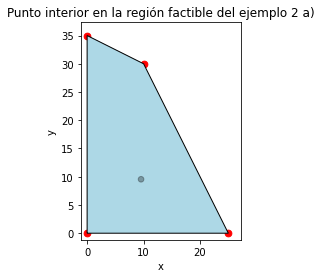

In [14]:
# Se declaran los semiespacios
halfspaces1 = np.array([[2, 1, -50],
                       [1, 2, -70]])

# Se lleva a cabo un proceso similar que en la función del punto 1. 
b = -1*halfspaces1[:,-1]
A = np.concatenate((halfspaces1[:,:-1],np.identity(halfspaces1.shape[0])),axis=1)
var2 = fun(A,b)
vertices = []

for item in list(var2['Factibles']):
    lista = list(item)
    vertices.append(lista[:2])

# Se declaran los semiespacios teniendo en cuenta las restricciones de x,y mayores o iguales a cero. 
halfspaces = np.array([[2, 1, -50],
                       [1, 2, -70],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Opciones para graficar.
options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title':'Punto interior en la región factible del ejemplo 2 a)'}

# Se hace el dibujo en 2D.
ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c = 'red' , marker = '.', s = 180) 

# Implementación del script del ejemplo.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

#Se encuentra el punto interior de la región factible graficada anteriormente usando la función linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Se crea un círculo en la solución óptima entragada por la función linprog.
circle = Circle(x, radius=0.5, alpha=0.3, color = 'black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c = 'black' , marker = '.', s = 180)

A continuación se muestra la implementación para el ejemplo 2 b)

,Solución,Base
0,"[30.0, 20.0, 0.0, 0.0, 20.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[10.0, 40.0, 0.0, 20.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[30.0, 40.0, 20.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


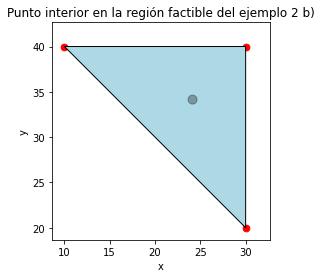

In [15]:
# Se declaran los semiespacios
halfspaces1 = np.array([[-1, -1, 50],
                       [1, 0, -30],
                      [0,1, -40]])

# Se declaran los semiespacios teniendo en cuenta las restricciones de x,y mayores o iguales a cero. 
halfspaces = np.array([[-1., -1., 50],
                       [1., 0, -30.], 
                       [0., 1, -40],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Se lleva a cabo un proceso similar que en la función del punto 1. 
b = -1*halfspaces1[:,-1]
A = np.concatenate((halfspaces1[:,:-1],np.identity(halfspaces1.shape[0])),axis=1)
var2 = fun(A,b)
vertices = []

for item in list(var2['Factibles']):
    lista = list(item)
    vertices.append(lista[:2])

options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title':'Punto interior en la región factible del ejemplo 2 b)'}

# Dibujar forma a partir de los puntos
ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c = 'red' , marker = '.', s = 180)

# Implementación del script del ejemplo.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

#Se encuentra el punto interior de la región factible graficada anteriormente usando la función linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Se crea un círculo en la solución óptima entragada por la función linprog.
circle = Circle(x, radius=0.5, alpha=0.3, color = 'black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c = 'black' , marker = '.', s = 180)

A continuación se muestra la implementación para el ejemplo 2 c)

,Solución,Base
0,"[0.727, 4.091, 0.0, 0.0, 5.909]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[1.2, 4.8, 0.0, 5.2, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[2.118, 2.353, 7.647, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


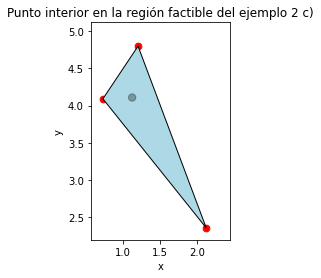

In [16]:
# Se declaran los semiespacios
halfspaces1 = np.array([[-3, 2, -6],
                       [-5, -4, 20],
                      [8,3, -24]])

# Se declaran los semiespacios teniendo en cuenta las restricciones de x,y mayores o iguales a cero. 
halfspaces = np.array([[-3., 2., -6],
                       [-5., -4, 20.],
                       [8, 3, -24],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Se lleva a cabo un proceso similar que en la función del punto 1. 
b = -1*halfspaces1[:,-1]
A = np.concatenate((halfspaces1[:,:-1],np.identity(halfspaces1.shape[0])),axis=1)
var2 = fun(A,b)
vertices = []

for item in list(var2['Factibles']):
    lista = list(item)
    vertices.append(lista[:2])

halfspaces = np.array([[-3., 2., -6],
                       [-5., -4, 20.],
                       [8, 3, -24],
                       [-1, 0, 0],
                       [0, -1, 0]])

options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title':'Punto interior en la región factible del ejemplo 2 c)'}

ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c = 'red' , marker = '.', s = 180) 

# Implementación del script del ejemplo.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

#Se encuentra el punto interior de la región factible graficada anteriormente usando la función linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Se crea un círculo en la solución óptima entragada por la función linprog.
circle = Circle(x, radius=0.05, alpha=0.3, color = 'black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c = 'black' , marker = '.', s = 180)